In [1]:
%matplotlib inline
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import numpy as np
import glob

from dask.distributed import Client, LocalCluster
from yahist import Hist1D, Hist2D

from condor_utils import make_htcondor_cluster

In [2]:
from utils import get_results, clear_tree_cache, plot_timeflow

In [3]:
cluster = make_htcondor_cluster(dashboard_address=12347)
cluster.scale(32)
cluster

In [5]:
client = Client(cluster)
client

Client Scheduler: tcp://169.228.130.74:14638 Dashboard: http://169.228.130.74:12347/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
client.wait_for_workers(24)

In [7]:
fnames = glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/DoubleEG_Run201*x3/*.root")
print(len(fnames))

256


In [8]:
# thread = utils.monitor_and_kill_stuck_workers(threshold=90.0, dryrun=False)

In [9]:
# del thread
# client.restart()

In [10]:
# Takes in a dataframe-like object based on a chunk of a file
# must return a dictionary of things that can be added with `+`
def process(df):
    out = dict()
    out["mycounter"] = len(df)
    out["hmet"] = Hist1D(df["MET_pt"], bins="1000,0,1000", label="MET_pt")
#     if "test_nanoaodSkim_34.root" in df.filename:
#         import time
#         time.sleep(100)
    return out

In [17]:
# results = get_results(process, fnames, use_tree_cache=True, chunksize=500e3)
results = get_results(process, fnames[:None], use_tree_cache=True, chunksize=500e3, skip_bad_files=True)

Making chunks for workers
Processing 715 chunks



Processed 3.0025e+08 input events in 106.1s (2830.36kHz)


In [18]:
# use_tree_cache speeds things up the second time you run on the same files (if you're looping on <200 files)
# so we run it again. In principle, `process` can be changed and we'll still see a speedup due to the
# overhead of opening up a nanoaod ttree with uproot

# results = get_results(process, fnames, use_tree_cache=True, chunksize=500e3)
results = get_results(process, fnames[:None], use_tree_cache=True, chunksize=500e3, skip_bad_files=True)

Making chunks for workers
Processing 715 chunks



Processed 3.0025e+08 input events in 66.1s (4542.18kHz)


distributed.scheduler - ERROR - Couldn't gather keys {'wrapper-6812ff48deecee926251354cbf020c71': ['tcp://169.228.132.111:41930']} state: ['memory'] workers: ['tcp://169.228.132.111:41930']
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.132.111:41930'], wrapper-6812ff48deecee926251354cbf020c71
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {'wrapper-0eff26c94ff8ef54a78f4d964ecd05cd': ['tcp://169.228.132.111:43247']} state: ['memory'] workers: ['tcp://169.228.132.111:43247']
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.132.111:43247'], wrapper-0eff26c94ff8ef54a78f4d964ecd05cd
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {'wrapper-53ef49af06cc8923c65d34dbf696edd1': ['tcp://169.228.132.103:46160']} state: ['memory'] workers: ['tcp://169.228.132.103:46160']
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.

In [16]:
# clear_tree_cache()

Client Scheduler: tcp://169.228.130.74:14638 Dashboard: http://169.228.130.74:12347/status,Cluster Workers: 31 Cores: 31 Memory: 124.00 GB


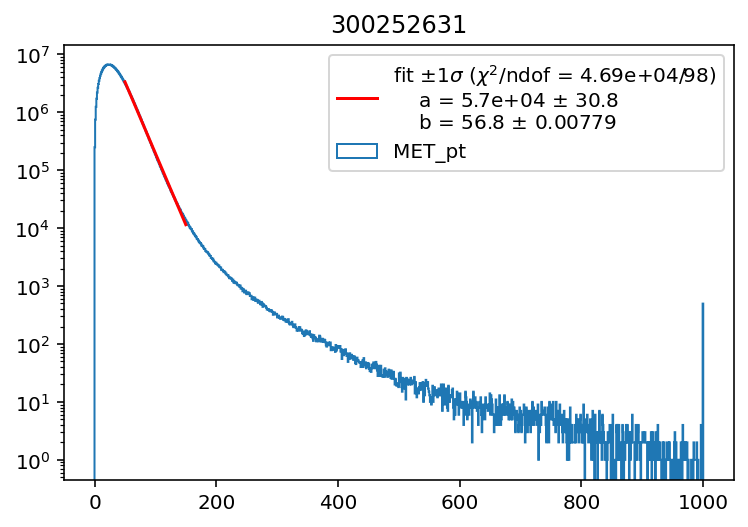

In [14]:
fig, ax = plt.subplots()

h = results["hmet"]

h.plot(histtype="step")
h.restrict(50, 150).fit("(a*1000)*np.exp(-b*x/1000)")

ax.set_title(str(results["mycounter"]))
ax.set_yscale("log")

In [15]:
plot_timeflow(results)

Loading BokehJS ...

In [36]:
[v["metrics"]["numtreescached"] for v in client._scheduler_identity["workers"].values()]

[10, 11, 10, 11, 10, 11, 12, 11]

In [34]:
import utils
chunks = utils.get_chunking(tuple(fnames[:2]), 500e3)[0]
chunk = chunks[0]

In [14]:
from utils import use_chunk_input, DataFrameWrapper

def testproc(df):
    out = dict()
    out["mycounter"] = len(df)
    _ = df["MET_pt"]
    return out

testproc = use_chunk_input(testproc, use_tree_cache=True)

In [21]:
def f():
    worker = get_worker()
    return list(worker.tree_cache.keys())
    
client.run(f, workers=["tcp://169.228.131.202:46093"])

{'tcp://169.228.131.202:46093': []}

In [22]:
%%time
res = client.gather(client.submit(testproc,chunk, workers=["tcp://169.228.131.202:46093"]))
# print(res)
print(res["t_stop"][0]-res["t_start"][0])
# client.gather(client.submit(testproc,chunk, workers=[]))

0.2763335704803467
CPU times: user 95 ms, sys: 7 ms, total: 102 ms
Wall time: 1.52 s
